## Training: Fitness Function

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
import os
os.chdir("..")
from sklearn.preprocessing import StandardScaler
from src.models.ordinal_classifier_fnn import *
from src.models.coral_loss import *
from src.data.ff_dataloader import *
from src.preprocessing.transform_into_model_data_ff import *
import torch.nn.functional as F

#### Set seeds

In [68]:
# Set seeds in order to reproduce results
torch.manual_seed(73)
random.seed(73)
np.random.seed(73)

#### Load dataset

In [69]:
# Replace by true labeled dataset if available
train_dataset = DatasetFF(train=True, path="data/fitness_function")
test_dataset = DatasetFF(train=False, path="data/fitness_function")

In [70]:
train_dataset.X

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0395,  0.0514, 24.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.7143,  0.7070, 24.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.7143,  0.7786, 24.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.6105,  0.4907, 24.0000],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.8615,  0.5000, 24.0000],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.6105,  0.4907, 24.0000]])

In [71]:
train_dataset.y

tensor([[1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        ...,
        [1., 1., 1., 0.],
        [1., 1., 0., 0.],
        [0., 0., 0., 0.]])

#### Scale training and test data

In [72]:
scaler = StandardScaler()

# only scale numeric variables that are not one-hot encoded
scaler.fit(train_dataset.X[:, 6:])
train_dataset.scale(scaler)
test_dataset.scale(scaler)

In [73]:
train_dataset.X

tensor([[ 0.0000,  0.0000,  0.0000,  ..., -1.8314, -1.9453,  0.0352],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.8470,  0.9393,  0.0352],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.8470,  1.2542,  0.0352],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.4349, -0.0121,  0.0352],
        [ 0.0000,  1.0000,  0.0000,  ...,  1.4314,  0.0286,  0.0352],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.4349, -0.0121,  0.0352]])

#### Build model and switch to GPU if available

In [74]:
fitness_function = OrdinalClassifierFNN(num_classes=5, layer_sizes=[38,28])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
fitness_function.to(device)

cpu


OrdinalClassifierFNN(
  (hidden): ModuleList(
    (0): Linear(in_features=38, out_features=28, bias=True)
  )
  (coral_weights): Linear(in_features=28, out_features=1, bias=False)
)

In [75]:
fitness_function(test_dataset.X[0])

tensor([0.7780, 0.5280, 0.2780, 0.0280], grad_fn=<AddBackward0>)

#### Define optimizer and additional measure to report (optional)

In [76]:
#criterion = nn.L1Loss()
report_measure = nn.L1Loss()
optimizer = torch.optim.Adam(fitness_function.parameters())

#### Define Data loaders

In [77]:
# Useful because it automatically generates batches in the training loop and takes care of shuffling

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

#### Model training

In [78]:
n_epochs = 150

# Stuff to store
train_losses = np.zeros(n_epochs)
train_maes = np.zeros(n_epochs)

test_losses = np.zeros(n_epochs)
test_maes = np.zeros(n_epochs)

for it in range(n_epochs):
    train_loss = []
    train_mae = []
    for inputs, targets in train_loader:
        # move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = fitness_function(inputs)
        loss = coral_loss(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        train_mae.append(report_measure(torch.sigmoid(outputs), targets).item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss)
    train_mae = np.mean(train_mae)

    test_loss = []
    test_mae = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = fitness_function(inputs)
        loss = coral_loss(outputs, targets)
        test_loss.append(loss.item())
        test_mae.append(report_measure(torch.sigmoid(outputs), targets).item())
    test_loss = np.mean(test_loss)
    test_mae = np.mean(test_mae)

    # Save losses
    train_losses[it] = train_loss
    train_maes[it] = train_mae
    test_losses[it] = test_loss
    test_maes[it] = test_mae

    if (it + 1) % 10 == 0 or it==0:
        print(f'Epoch {it + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f},'
              f' Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}')

Epoch 1/150, Train Loss: 2.5562, Test Loss: 2.3483, Train MAE: 0.4620, Test MAE: 0.4367
Epoch 10/150, Train Loss: 2.0267, Test Loss: 2.0601, Train MAE: 0.3702, Test MAE: 0.3747
Epoch 20/150, Train Loss: 1.8778, Test Loss: 1.9308, Train MAE: 0.3388, Test MAE: 0.3453
Epoch 30/150, Train Loss: 1.7910, Test Loss: 1.8588, Train MAE: 0.3177, Test MAE: 0.3261
Epoch 40/150, Train Loss: 1.7338, Test Loss: 1.8303, Train MAE: 0.3028, Test MAE: 0.3130
Epoch 50/150, Train Loss: 1.6986, Test Loss: 1.8118, Train MAE: 0.2920, Test MAE: 0.3029
Epoch 60/150, Train Loss: 1.6728, Test Loss: 1.7976, Train MAE: 0.2835, Test MAE: 0.2958
Epoch 70/150, Train Loss: 1.6571, Test Loss: 1.8022, Train MAE: 0.2781, Test MAE: 0.2915
Epoch 80/150, Train Loss: 1.6439, Test Loss: 1.7994, Train MAE: 0.2733, Test MAE: 0.2877
Epoch 90/150, Train Loss: 1.6373, Test Loss: 1.8010, Train MAE: 0.2696, Test MAE: 0.2843
Epoch 100/150, Train Loss: 1.6313, Test Loss: 1.8116, Train MAE: 0.2673, Test MAE: 0.2829
Epoch 110/150, Train 


#### Plot the train loss and test loss per iteration

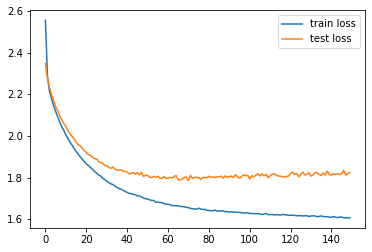

In [79]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

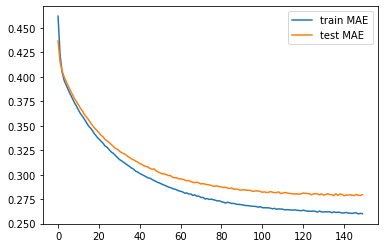

In [80]:
plt.plot(train_maes, label='train MAE')
plt.plot(test_maes, label='test MAE')
plt.legend()
plt.show()

#### Save trained model

In [81]:
torch.save(fitness_function.state_dict(), "models/best_fitness_function_path.pth")

#### Load model and make predictions

In [82]:
model = OrdinalClassifierFNN(num_classes=5, layer_sizes=[38,28])
model.load_state_dict(torch.load("models/best_fitness_function_path.pth"))
model.eval()

OrdinalClassifierFNN(
  (hidden): ModuleList(
    (0): Linear(in_features=38, out_features=28, bias=True)
  )
  (coral_weights): Linear(in_features=28, out_features=1, bias=False)
)

In [86]:
random_input = torch.from_numpy(np.random.normal(size=[1, 38]).astype(np.float32))

output = model(random_input)

In [87]:
output

tensor([[ 4.0959,  2.6863,  1.1206, -0.8579]], grad_fn=<AddBackward0>)

In [85]:
decode_classes(output)

array([[0]])